In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import LatentDirichletAllocation 
import numpy as np
import pandas as pd
import pickle
# import texthero as hero

In [3]:
data=pd.read_csv('singapore_trip_advisor_data_cleaned.csv')

In [4]:
data.head()

,REVIEW_INDEX,REVIEW_DATE,REVIEW_RATING,REVIEW_TITLE,REVIEW_BODY,DATE_OF_EXPERIENCE,TRIP_TYPE,REVIEW_CRAWLED_TIME,REVIEWER_NAME,HOME_COUNTRY,ATTRACTION_NAME,ATTRACTION_TYPE,ADDRESS,clean_text
0,741832336,2020-01-29 00:00:00.000,5,Fabulous,Fabulous experience and an unforgettable day o...,2020-01-01 00:00:00.000,Couples,2020-01-29 12:01:27.012,Dreinog,United Kingdom,Cloud Forest,Leisure & Recreation,18 Marina Gardens Drive | 18 Marina Gardens Dr...,fabulous experience unforgettable day singapor...
1,741819214,2020-01-29 00:00:00.000,5,Stunning,I wasnâ€™t sure what to expect but this was ab...,2020-01-01 00:00:00.000,Family,2020-01-29 11:30:13.663,3mcglynns,Australia,Cloud Forest,Leisure & Recreation,18 Marina Gardens Drive | 18 Marina Gardens Dr...,wasnatmt sure expect absolutely beautiful moth...
2,741818972,2020-01-29 00:00:00.000,3,Another Chinatown,As every major city worldwide seems to have a ...,2020-01-01 00:00:00.000,Couples,2020-01-30 11:53:44.082,MR_Travels1920,United Kingdom,Chinatown,Precinct & Street,"Crot | Trengganu, Singapore 048942, Singapore",every major city worldwide seem chinatown anot...
3,741881009,2020-01-29 00:00:00.000,4,Good lively place to visit,Busy lively place in the evening I visited. Go...,2020-01-01 00:00:00.000,Solo,2020-01-30 12:34:12.312,RaviA651,United States,Chinatown,Precinct & Street,"Crot | Trengganu, Singapore 048942, Singapore",busy lively place even visit go empty stomach ...
4,741827762,2020-01-29 00:00:00.000,5,Great experience,Fabulous location and atmosphere. We only stop...,2020-01-01 00:00:00.000,Couples,2020-01-29 23:02:07.201,Dreinog,United Kingdom,Marina Bay,Precinct & Street,"Marina Boulevard, Singapore 018980, Singapore",fabulous location atmosphere stop day return s...


In [5]:
atypes = list(data['ATTRACTION_TYPE'].value_counts().index)

In [6]:
data['ATTRACTION_TYPE'].value_counts(normalize = True)

Leisure & Recreation      0.578301
Precinct & Street         0.153441
Nature & Wildlife         0.144479
Art, History & Culture    0.123779
Name: ATTRACTION_TYPE, dtype: float64

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Leisure & Recreation'),
  Text(1, 0, 'Precinct & Street'),
  Text(2, 0, 'Art, History & Culture'),
  Text(3, 0, 'Nature & Wildlife')])

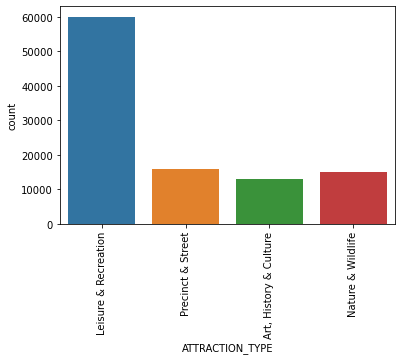

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x = data['ATTRACTION_TYPE'])
plt.xticks(rotation = 90)

## Leisure & Recreation

In [8]:
df0 = data[data['ATTRACTION_TYPE']==atypes[0]]
# vectorize text data
vectorizer = TfidfVectorizer()
vectorizer.fit(df0['clean_text'])

# save the model to disk
#filename_vec = 'vectorizer_model.sav'
#pickle.dump(vectorizer, open(filename_vec, 'wb'))

# transform the text into vectorizer
X0 = vectorizer.transform(df0['clean_text'])


In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

sil0 = []
sse0 = []
kmax = 9

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax+1)):
    kmeans = KMeans(n_clusters = k).fit(X0)
    labels = kmeans.labels_
    sse0.append(kmeans.inertia_)
    sil0.append(silhouette_score(X0, labels, metric = 'euclidean'))

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [26:41<00:00, 200.16s/it]


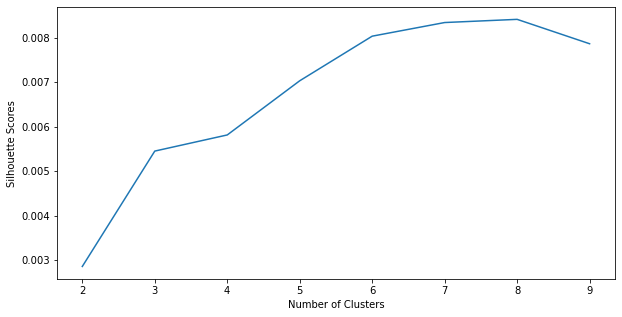

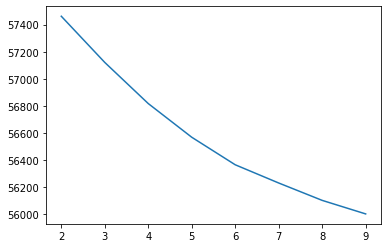

In [10]:
plt.figure(figsize = (10,5))
sns.lineplot(x = list(range(2,kmax+1)), y = sil0)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Scores')
plt.show()
sns.lineplot(x = list(range(2,kmax+1)), y = sse0)
plt.show()

In [11]:
# generate topics for each attraction type
# build LDA model
lda0 = LatentDirichletAllocation(n_components=6, max_iter=10, learning_method='online', learning_offset=5, random_state=2017)
lda0.fit(X0)

# save the model to disk
#filename_lda = 'lda_model.sav'
#pickle.dump(lda, open(filename_lda, 'wb'))

feature_names0 = np.array(vectorizer.get_feature_names())
for topic_idx, topic in enumerate(lda0.components_):
    print('Attraction type: {}'.format(atypes[0]))
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names0[i] for i in topic.argsort()[:-10 - 1:-1]]))

Attraction type: Leisure & Recreation
Topic #0:
expect tropical outdoor escape wide waterfront humidity hang greenhouse greenery
Attraction type: Leisure & Recreation
Topic #1:
outstanding tranquil trail concert vip creative tram sightsee adventure concept
Attraction type: Leisure & Recreation
Topic #2:
view ride car flyer get sentosa cable bar hotel ticket
Attraction type: Leisure & Recreation
Topic #3:
road boat conditioning east bike expectation coast keen beach cycling
Attraction type: Leisure & Recreation
Topic #4:
mountain cold season control fauna work let old jacket exit
Attraction type: Leisure & Recreation
Topic #5:
garden visit place see singapore walk not flower dome go


In [12]:
mat0 = lda0.transform(X0) 

topic_dist0 = mat0

labels0 = [-1]*len(topic_dist0)
    
i = 0
for dist in topic_dist0:
    dist = dist.tolist()
    if len(set(dist)) != 1:
        review_topic_index = dist.index(max(dist))
        review_max_topic_probality = dist[review_topic_index]
        labels0[i]=review_topic_index
        i = i + 1
    else:
        i = i + 1

labels_df0 = pd.DataFrame(labels0)

In [13]:
labels_df0 = labels_df0.rename(columns = {0:'Topic'})
df_LR = pd.concat([df0.reset_index(), labels_df0],axis=1)

df_LR['Topic'] = df_LR['Topic'].replace({
    0: 'Flowers and Plants', 
    1: 'Service',
    2: 'Transportation and Tickets',
    3: 'Entertainments and Activities',
    4: 'Indoor Environment',
    5: 'Garden Tour'
})

df_LR.head()

,index,REVIEW_INDEX,REVIEW_DATE,REVIEW_RATING,REVIEW_TITLE,REVIEW_BODY,DATE_OF_EXPERIENCE,TRIP_TYPE,REVIEW_CRAWLED_TIME,REVIEWER_NAME,HOME_COUNTRY,ATTRACTION_NAME,ATTRACTION_TYPE,ADDRESS,clean_text,Topic
0,0,741832336,2020-01-29 00:00:00.000,5,Fabulous,Fabulous experience and an unforgettable day o...,2020-01-01 00:00:00.000,Couples,2020-01-29 12:01:27.012,Dreinog,United Kingdom,Cloud Forest,Leisure & Recreation,18 Marina Gardens Drive | 18 Marina Gardens Dr...,fabulous experience unforgettable day singapor...,Garden Tour
1,1,741819214,2020-01-29 00:00:00.000,5,Stunning,I wasnâ€™t sure what to expect but this was ab...,2020-01-01 00:00:00.000,Family,2020-01-29 11:30:13.663,3mcglynns,Australia,Cloud Forest,Leisure & Recreation,18 Marina Gardens Drive | 18 Marina Gardens Dr...,wasnatmt sure expect absolutely beautiful moth...,Garden Tour
2,9,741766715,2020-01-28 00:00:00.000,5,Great place,Perhaps the best attraction in Singapore ... v...,2020-01-01 00:00:00.000,Couples,2020-01-29 10:38:29.069,OHIduke,United Kingdom,National Orchid Garden,Leisure & Recreation,1 Cluny Rd | Within the Singapore Botanic Gard...,perhaps best attraction singapore well preserv...,Garden Tour
3,10,741810174,2020-01-28 00:00:00.000,5,Family trip to Singapore,View of whole Singapore from floor no. 56 is v...,2020-01-01 00:00:00.000,Family,2020-01-29 13:09:47.153,vaibhav_maheshwari56,India,Marina Bay Sands Skypark,Leisure & Recreation,"10 Bayfront Avenue | Level 57, Marina Bay Sand...",view whole singapore floor amaze beautiful nic...,Garden Tour
4,11,741680428,2020-01-28 00:00:00.000,4,Expensive but fantastic views,"It has to be done, visit this iconic building,...",2020-01-01 00:00:00.000,Couples,2020-01-29 13:29:07.441,FionaH252,United Kingdom,Marina Bay Sands Skypark,Leisure & Recreation,"10 Bayfront Avenue | Level 57, Marina Bay Sand...",do visit iconic building travel top see singap...,Transportation and Tickets


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Garden Tour'),
  Text(1, 0, 'Transportation and Tickets'),
  Text(2, 0, 'Indoor Environment'),
  Text(3, 0, 'Service'),
  Text(4, 0, 'Flowers and Plants'),
  Text(5, 0, 'Entertainments and Activities')])

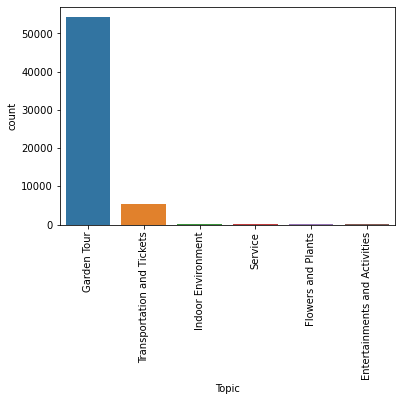

In [64]:
sns.countplot(x = df_LR['Topic'])
plt.xticks(rotation = 90)

In [14]:
# df_LR.to_csv('Leisure_and_Recreation_labelled.csv', sep=';')

NameError: name 'df' is not defined

## Precinct & Street

In [15]:
atypes[1]

'Precinct & Street'

In [16]:
# generate topics for each attraction type
df1 = data[data['ATTRACTION_TYPE']==atypes[1]]
# vectorize text data
vectorizer = TfidfVectorizer()
vectorizer.fit(df1['clean_text'])

# save the model to disk
#filename_vec = 'vectorizer_model.sav'
#pickle.dump(vectorizer, open(filename_vec, 'wb'))

# transform the text into vectorizer
X1 = vectorizer.transform(df1['clean_text'])

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

sil1 = []
sse1 = []
kmax = 9

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax+1)):
    kmeans = KMeans(n_clusters = k).fit(X1)
    labels = kmeans.labels_
    sil1.append(silhouette_score(X1, labels, metric = 'euclidean'))
    sse1.append(kmeans.inertia_)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:01<00:00, 45.24s/it]


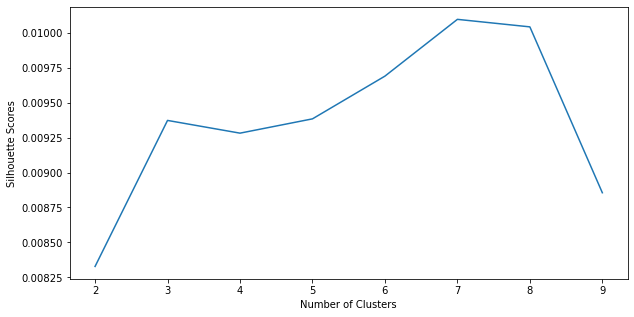

<AxesSubplot:>

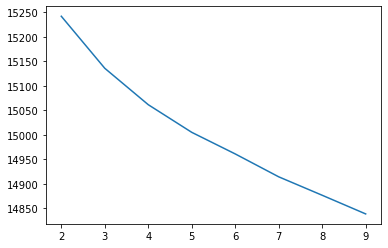

In [18]:
plt.figure(figsize = (10,5))
sns.lineplot(x = list(range(2,kmax+1)), y = sil1)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Scores')
plt.show()
sns.lineplot(x = list(range(2,kmax+1)), y = sse1)

In [19]:
# build LDA model
lda1 = LatentDirichletAllocation(n_components=3, max_iter=10, learning_method='online', learning_offset=5, random_state=2017)
lda1.fit(X1)

# save the model to disk
#filename_lda = 'lda_model.sav'
#pickle.dump(lda, open(filename_lda, 'wb'))

feature_names1 = np.array(vectorizer.get_feature_names())
for topic_idx, topic in enumerate(lda1.components_):
    print('Attraction type: {}'.format(atypes[1]))
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names1[i] for i in topic.argsort()[:-10 - 1:-1]]))

Attraction type: Precinct & Street
Topic #0:
bay night marina view river light quay place walk singapore
Attraction type: Precinct & Street
Topic #1:
shop food shopping place not street visit good road singapore
Attraction type: Precinct & Street
Topic #2:
glam kampong hong kong na belt refund stomach wan convenience


In [20]:
mat1 = lda1.transform(X1) 

topic_dist1 = mat1

labels1 = [-1]*len(topic_dist1)
    
i = 0
for dist in topic_dist1:
    dist = dist.tolist()
    if len(set(dist)) != 1:
        review_topic_index = dist.index(max(dist))
        review_max_topic_probality = dist[review_topic_index]
        labels1[i]=review_topic_index
        i = i + 1
    else:
        i = i + 1

labels_df1 = pd.DataFrame(labels1)

In [21]:
labels_df1 = labels_df1.rename(columns = {0:'Topic'})
df_PS = pd.concat([df1.reset_index(), labels_df1],axis=1)

df_PS['Topic'] = df_PS['Topic'].replace({
    0: 'Nightlife', 
    1: 'Shopping and Restaurant',
    2: 'Cultural Atmosphere',
})

df_PS.head()

,index,REVIEW_INDEX,REVIEW_DATE,REVIEW_RATING,REVIEW_TITLE,REVIEW_BODY,DATE_OF_EXPERIENCE,TRIP_TYPE,REVIEW_CRAWLED_TIME,REVIEWER_NAME,HOME_COUNTRY,ATTRACTION_NAME,ATTRACTION_TYPE,ADDRESS,clean_text,Topic
0,2,741818972,2020-01-29 00:00:00.000,3,Another Chinatown,As every major city worldwide seems to have a ...,2020-01-01 00:00:00.000,Couples,2020-01-30 11:53:44.082,MR_Travels1920,United Kingdom,Chinatown,Precinct & Street,"Crot | Trengganu, Singapore 048942, Singapore",every major city worldwide seem chinatown anot...,Shopping and Restaurant
1,3,741881009,2020-01-29 00:00:00.000,4,Good lively place to visit,Busy lively place in the evening I visited. Go...,2020-01-01 00:00:00.000,Solo,2020-01-30 12:34:12.312,RaviA651,United States,Chinatown,Precinct & Street,"Crot | Trengganu, Singapore 048942, Singapore",busy lively place even visit go empty stomach ...,Shopping and Restaurant
2,4,741827762,2020-01-29 00:00:00.000,5,Great experience,Fabulous location and atmosphere. We only stop...,2020-01-01 00:00:00.000,Couples,2020-01-29 23:02:07.201,Dreinog,United Kingdom,Marina Bay,Precinct & Street,"Marina Boulevard, Singapore 018980, Singapore",fabulous location atmosphere stop day return s...,Nightlife
3,6,741865751,2020-01-29 00:00:00.000,4,A different â€˜sideâ€™ of Orchard Road,I came here during the Chinese New Year. It wa...,2020-01-01 00:00:00.000,Family,2020-01-30 02:21:23.583,588phis,Thailand,Orchard Road,Precinct & Street,"Singapore, Singapore",come chinese new year rather quiet not crowd a...,Shopping and Restaurant
4,13,741728919,2020-01-28 00:00:00.000,5,Awesime view by night,Just outside the main shopping center in City ...,2020-01-01 00:00:00.000,Couples,2020-01-29 23:02:07.596,soebagij,Indonesia,Marina Bay,Precinct & Street,"Marina Boulevard, Singapore 018980, Singapore",outside main shopping center city hall suntec ...,Nightlife


(array([0, 1, 2]),
 [Text(0, 0, 'Shopping and Restaurant'),
  Text(1, 0, 'Nightlife'),
  Text(2, 0, 'Cultural Atmosphere')])

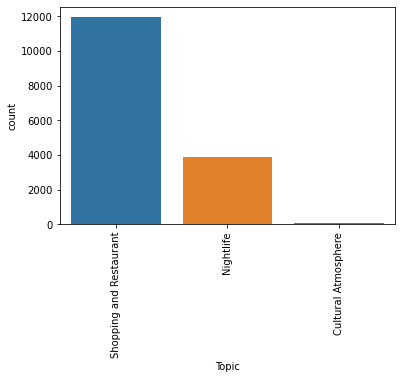

In [65]:
sns.countplot(x = df_PS['Topic'])
plt.xticks(rotation = 90)

## Nature & Wildlife

In [22]:
atypes[2]

'Nature & Wildlife'

In [23]:
# generate topics for each attraction type
df2 = data[data['ATTRACTION_TYPE']==atypes[2]]
# vectorize text data
vectorizer = TfidfVectorizer()
vectorizer.fit(df2['clean_text'])

# save the model to disk
#filename_vec = 'vectorizer_model.sav'
#pickle.dump(vectorizer, open(filename_vec, 'wb'))

# transform the text into vectorizer
X2 = vectorizer.transform(df2['clean_text'])

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

sil2 = []
sse2 = []
kmax = 9

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax+1)):
    kmeans = KMeans(n_clusters = k).fit(X2)
    labels = kmeans.labels_
    sse2.append(kmeans.inertia_)
    sil2.append(silhouette_score(X2, labels, metric = 'euclidean'))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [05:01<00:00, 37.63s/it]


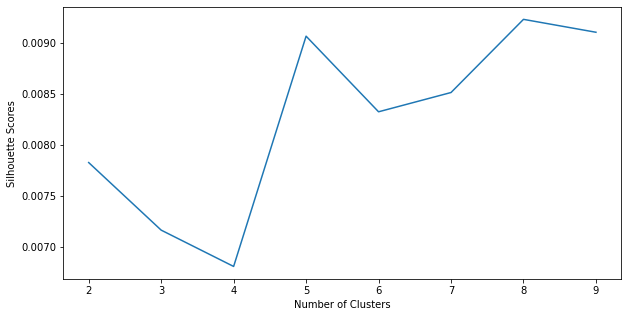

<AxesSubplot:>

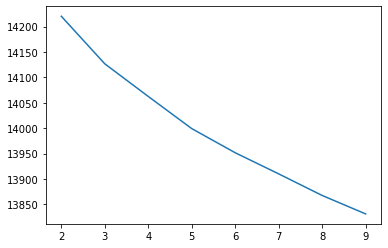

In [25]:
plt.figure(figsize = (10,5))
sns.lineplot(x = list(range(2,kmax+1)), y = sil2)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Scores')
plt.show()
sns.lineplot(x = list(range(2,kmax+1)), y = sse2)

In [26]:
# build LDA model
lda2 = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online', learning_offset=5, random_state=2017)
lda2.fit(X2)
# save the model to disk
#filename_lda = 'lda_model.sav'
#pickle.dump(lda, open(filename_lda, 'wb'))

feature_names2 = np.array(vectorizer.get_feature_names())
for topic_idx, topic in enumerate(lda2.components_):
    print('Attraction type: {}'.format(atypes[2]))
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names2[i] for i in topic.argsort()[:-10 - 1:-1]]))

Attraction type: Nature & Wildlife
Topic #0:
airport van shinto dr hsbc litter keppel jinja syonan ye
Attraction type: Nature & Wildlife
Topic #1:
koala setup couldnt promotion equally youngster komodo foreigner law bali
Attraction type: Nature & Wildlife
Topic #2:
affordable orangatans dec kusu mai granddaughter temple john sumatran lifestyle
Attraction type: Nature & Wildlife
Topic #3:
zoo animal not see visit show bird night walk well
Attraction type: Nature & Wildlife
Topic #4:
wetland attractive esp hectic kranji goat mudskipper buloh sungei expand


In [27]:
mat2 = lda2.transform(X2) 

topic_dist2 = mat2

labels2 = [-1]*len(topic_dist2)
    
i = 0
for dist in topic_dist2:
    dist = dist.tolist()
    if len(set(dist)) != 1:
        review_topic_index = dist.index(max(dist))
        review_max_topic_probality = dist[review_topic_index]
        labels2[i]=review_topic_index
        i = i + 1
    else:
        i = i + 1

labels_df2 = pd.DataFrame(labels2)

In [28]:
labels_df2 = labels_df2.rename(columns = {0:'Topic'})
df_NW = pd.concat([df2.reset_index(), labels_df2],axis=1)

df_NW['Topic'] = df_NW['Topic'].replace({
    0: 'Environment', 
    1: 'Animal Show',
    2: 'Exploration Efficiency',
    3: 'Interaction with Animals',
    4: 'Nature'
})

df_NW.head()

,index,REVIEW_INDEX,REVIEW_DATE,REVIEW_RATING,REVIEW_TITLE,REVIEW_BODY,DATE_OF_EXPERIENCE,TRIP_TYPE,REVIEW_CRAWLED_TIME,REVIEWER_NAME,HOME_COUNTRY,ATTRACTION_NAME,ATTRACTION_TYPE,ADDRESS,clean_text,Topic
0,7,741821943,2020-01-29 00:00:00.000,5,Great day out,"I loved this! We did an afternoon tour here, w...",2020-01-01 00:00:00.000,Family,2020-01-30 03:42:08.473,3mcglynns,Australia,River Safari,Nature & Wildlife,80 Mandai Lake Road Singapore Zoological Garde...,love afternoon tour stayed hour well laid supe...,Interaction with Animals
1,14,741734127,2020-01-28 00:00:00.000,4,Nice walk,Great place to be in the nature on such concre...,2020-01-01 00:00:00.000,Friends,2020-01-29 23:51:38.342,Michelle M,Switzerland,MacRitchie Nature Trail,Nature & Wildlife,"MacRitchie Reservoir Park, Singapore 298717, S...",great place nature concrete jungle love wildli...,Interaction with Animals
2,18,741422340,2020-01-27 00:00:00.000,4,A great place for family bonding,A place with history and a place to relax with...,2020-01-01 00:00:00.000,Family,2020-01-31 17:22:56.722,juleskarz,Singapore,Labrador Nature Reserve,Nature & Wildlife,"Labrador Villa Road Tanjong Berlayer Park, Sin...",place history place relax family love greenery...,Interaction with Animals
3,23,741335601,2020-01-26 00:00:00.000,5,Jurong bird park.,It is superb and marvellous. Take a ram and dr...,2020-01-01 00:00:00.000,Couples,2020-01-29 17:46:29.258,564sanja,India,Jurong Bird Park,Nature & Wildlife,"2 Jurong Hill Jurong Bird Park, Singapore 6289...",superb marvellous take ram drop station see th...,Interaction with Animals
4,26,741206607,2020-01-26 00:00:00.000,4,Excellent walking trials,Excellent place for trekking and jogging. It h...,2020-01-01 00:00:00.000,Friends,2020-01-29 23:51:38.658,Kingkrk,Singapore,MacRitchie Nature Trail,Nature & Wildlife,"MacRitchie Reservoir Park, Singapore 298717, S...",excellent place trek jogging many trial tree t...,Interaction with Animals


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Interaction with Animals'),
  Text(1, 0, 'Environment'),
  Text(2, 0, 'Nature'),
  Text(3, 0, 'Animal Show'),
  Text(4, 0, 'Exploration Efficiency')])

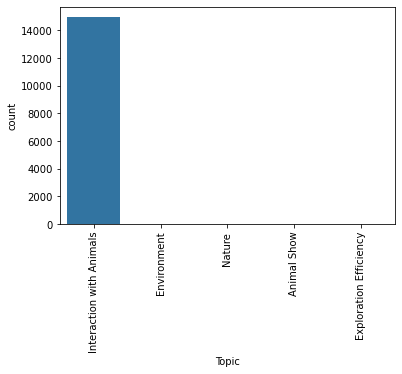

In [62]:
sns.countplot(x = df_NW['Topic'])
plt.xticks(rotation = 90)

## Art, History & Culture

In [29]:
atypes[3]

'Art, History & Culture'

In [30]:
# generate topics for each attraction type
df3 = data[data['ATTRACTION_TYPE']==atypes[3]]
# vectorize text data
vectorizer = TfidfVectorizer()
vectorizer.fit(df3['clean_text'])

# save the model to disk
#filename_vec = 'vectorizer_model.sav'
#pickle.dump(vectorizer, open(filename_vec, 'wb'))

# transform the text into vectorizer
X3 = vectorizer.transform(df3['clean_text'])

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

sil3 = []
sse3 = []
kmax = 9

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax+1)):
    kmeans = KMeans(n_clusters = k).fit(X3)
    labels = kmeans.labels_
    sse3.append(kmeans.inertia_)
    sil3.append(silhouette_score(X3, labels, metric = 'euclidean'))

100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [7:25:22<00:00, 3340.33s/it]


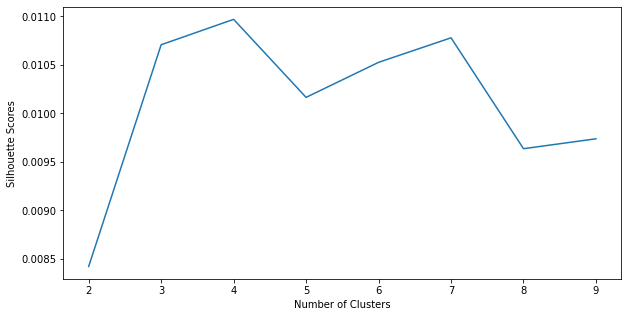

<AxesSubplot:>

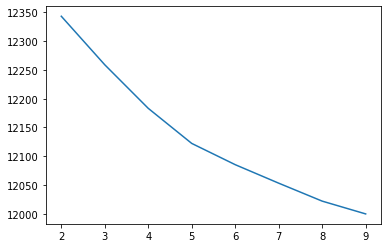

In [32]:
plt.figure(figsize = (10,5))
sns.lineplot(x = list(range(2,kmax+1)), y = sil3)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Scores')
plt.show()
sns.lineplot(x = list(range(2,kmax+1)), y = sse3)

In [33]:
# build LDA model
lda3 = LatentDirichletAllocation(n_components=4, max_iter=10, learning_method='online', learning_offset=5, random_state=2017)
lda3.fit(X3)
# save the model to disk
#filename_lda = 'lda_model.sav'
#pickle.dump(lda, open(filename_lda, 'wb'))

feature_names3 = np.array(vectorizer.get_feature_names())
for topic_idx, topic in enumerate(lda3.components_):
    print('Attraction type: {}'.format(atypes[3]))
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names3[i] for i in topic.argsort()[:-10 - 1:-1]]))

Attraction type: Art, History & Culture
Topic #0:
peranakan alvin wear intan shoulder culture host owner shawl skirt
Attraction type: Art, History & Culture
Topic #1:
singapore visit place not museum see tour temple take well
Attraction type: Art, History & Culture
Topic #2:
merlion bay lion park boat marina icon river water landmark
Attraction type: Art, History & Culture
Topic #3:
hop meaning vision christmas marvelous andrew whale budha yin gothic


In [34]:
mat3 = lda3.transform(X3) 

topic_dist3 = mat3

labels3 = [-1]*len(topic_dist3)
    
i = 0
for dist in topic_dist3:
    dist = dist.tolist()
    if len(set(dist)) != 1:
        review_topic_index = dist.index(max(dist))
        review_max_topic_probality = dist[review_topic_index]
        labels3[i]=review_topic_index
        i = i + 1
    else:
        i = i + 1

labels_df3 = pd.DataFrame(labels3)

In [38]:
df_AHC[df_AHC['Topic']==3]

,index,REVIEW_INDEX,REVIEW_DATE,REVIEW_RATING,REVIEW_TITLE,REVIEW_BODY,DATE_OF_EXPERIENCE,TRIP_TYPE,REVIEW_CRAWLED_TIME,REVIEWER_NAME,HOME_COUNTRY,ATTRACTION_NAME,ATTRACTION_TYPE,ADDRESS,clean_text,Topic


In [39]:
labels_df3 = labels_df3.rename(columns = {0:'Topic'})
df_AHC = pd.concat([df3.reset_index(), labels_df3],axis=1)

df_AHC['Topic'] = df_AHC['Topic'].replace({
    0: 'Cultural Atmosphere', 
    1: 'Artwork Quality',
    2: 'View',
    3: 'Temple History',
})

df_AHC.head()

,index,REVIEW_INDEX,REVIEW_DATE,REVIEW_RATING,REVIEW_TITLE,REVIEW_BODY,DATE_OF_EXPERIENCE,TRIP_TYPE,REVIEW_CRAWLED_TIME,REVIEWER_NAME,HOME_COUNTRY,ATTRACTION_NAME,ATTRACTION_TYPE,ADDRESS,clean_text,Topic
0,5,741822483,2020-01-29 00:00:00.000,4,Photo Spot,The Merlion is the symbolic sculpture of Singa...,2020-01-01 00:00:00.000,Couples,2020-01-30 01:48:09.408,MR_Travels1920,United Kingdom,Merlion Park,"Art, History & Culture","1 Fullerton Road One Fullerton | Merlion Park,...",merlion symbolic sculpture singapore centrally...,Artwork Quality
1,8,741821081,2020-01-29 00:00:00.000,4,New Year's Eve,We had an amazing experience watching the fire...,2020-01-01 00:00:00.000,Couples,2020-01-30 05:55:55.372,MR_Travels1920,United Kingdom,The Helix Bridge,"Art, History & Culture","Linking between Marina Bay and Marina Centre, ...",amaze experience watch firework drone helix br...,Artwork Quality
2,12,741644516,2020-01-28 00:00:00.000,4,Good history lesson,We got there for a free 1-hour tour in English...,2020-01-01 00:00:00.000,Couples,2020-01-29 19:33:34.847,tinymomkaren,United States,National Museum of Singapore,"Art, History & Culture","93 Stamford Road National Museum of Singapore,...",get free hour tour english early afternoon gui...,Artwork Quality
3,15,741644880,2020-01-28 00:00:00.000,5,You MUST see the Tang Shipwreck,"This museum has many wonderful things, but the...",2020-01-01 00:00:00.000,Couples,2020-01-30 05:32:24.128,tinymomkaren,United States,Asian Civilisations Museum,"Art, History & Culture","1 Empress Place Empress Place Building, Singap...",museum many wonderful thing cargo year old tan...,Artwork Quality
4,28,741363647,2020-01-26 00:00:00.000,4,You Havenâ€™t Been To Singapore If...,There are a couple things that people will tel...,2019-11-01 00:00:00.000,Couples,2020-01-30 01:48:09.779,gconti82,United States,Merlion Park,"Art, History & Culture","1 Fullerton Road One Fullerton | Merlion Park,...",couple thing people tell must seendone visit s...,Artwork Quality


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Artwork Quality'),
  Text(1, 0, 'View'),
  Text(2, 0, 'Temple History'),
  Text(3, 0, 'Cultural Atmosphere')])

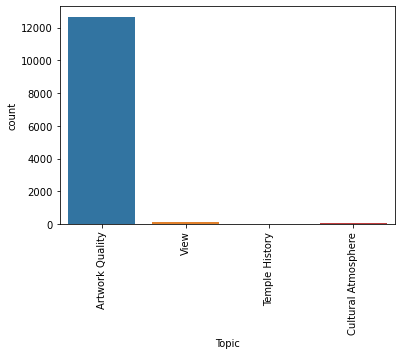

In [63]:
sns.countplot(x = df_AHC['Topic'])
plt.xticks(rotation = 90)

In [40]:
df = pd.concat([df_LR, df_PS, df_NW, df_AHC], ignore_index=True)
df = df.drop('index',axis = 1)

In [50]:
df['REVIEW_BODY']= df['REVIEW_BODY'].str.replace(',', " ")
df['ADDRESS']= df['ADDRESS'].str.replace(',', " ")


In [53]:
df.to_csv('named_topics_by_type.csv', sep= ';', index = True)

In [52]:
df.head()

,REVIEW_INDEX,REVIEW_DATE,REVIEW_RATING,REVIEW_TITLE,REVIEW_BODY,DATE_OF_EXPERIENCE,TRIP_TYPE,REVIEW_CRAWLED_TIME,REVIEWER_NAME,HOME_COUNTRY,ATTRACTION_NAME,ATTRACTION_TYPE,ADDRESS,clean_text,Topic
0,741832336,2020-01-29 00:00:00.000,5,Fabulous,Fabulous experience and an unforgettable day o...,2020-01-01 00:00:00.000,Couples,2020-01-29 12:01:27.012,Dreinog,United Kingdom,Cloud Forest,Leisure & Recreation,18 Marina Gardens Drive | 18 Marina Gardens Dr...,fabulous experience unforgettable day singapor...,Garden Tour
1,741819214,2020-01-29 00:00:00.000,5,Stunning,I wasnâ€™t sure what to expect but this was ab...,2020-01-01 00:00:00.000,Family,2020-01-29 11:30:13.663,3mcglynns,Australia,Cloud Forest,Leisure & Recreation,18 Marina Gardens Drive | 18 Marina Gardens Dr...,wasnatmt sure expect absolutely beautiful moth...,Garden Tour
2,741766715,2020-01-28 00:00:00.000,5,Great place,Perhaps the best attraction in Singapore ... v...,2020-01-01 00:00:00.000,Couples,2020-01-29 10:38:29.069,OHIduke,United Kingdom,National Orchid Garden,Leisure & Recreation,1 Cluny Rd | Within the Singapore Botanic Gard...,perhaps best attraction singapore well preserv...,Garden Tour
3,741810174,2020-01-28 00:00:00.000,5,Family trip to Singapore,View of whole Singapore from floor no. 56 is v...,2020-01-01 00:00:00.000,Family,2020-01-29 13:09:47.153,vaibhav_maheshwari56,India,Marina Bay Sands Skypark,Leisure & Recreation,10 Bayfront Avenue | Level 57 Marina Bay Sand...,view whole singapore floor amaze beautiful nic...,Garden Tour
4,741680428,2020-01-28 00:00:00.000,4,Expensive but fantastic views,It has to be done visit this iconic building ...,2020-01-01 00:00:00.000,Couples,2020-01-29 13:29:07.441,FionaH252,United Kingdom,Marina Bay Sands Skypark,Leisure & Recreation,10 Bayfront Avenue | Level 57 Marina Bay Sand...,do visit iconic building travel top see singap...,Transportation and Tickets
